# Undo Stationary transformation

In [1]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

import warnings
warnings.filterwarnings("ignore")

In [2]:
def adf_test(series):
    results = adfuller(series)
    print("ADF statistic: %f"% results[0])
    print("p-value: %f"%results[1])

In [3]:
#read data
"""this datasets contains the viewers of a youtube video..first col represent the hour since uploading the video and 
the 2nd col shows the viewers"""

ts = pd.read_csv("original_series.csv")
ts

,0
0,956.438486
1,7284.907174
2,11357.870166
3,13622.652007
4,17137.455304
...,...
67,42204.338905
68,42368.641039
69,42564.988401
70,42606.297399


Text(0, 0.5, 'Views')

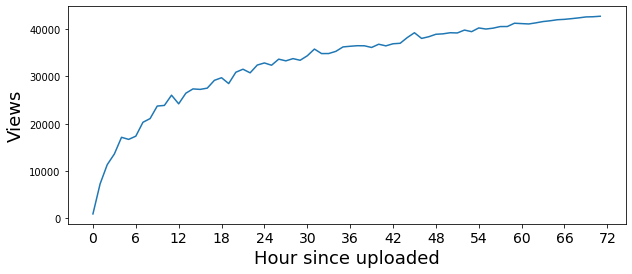

In [4]:
plt.figure(figsize = (10,4))
plt.plot(ts)
plt.xlabel("Hour since uploaded", fontsize = 18)
plt.xticks(np.arange(0,78,6), fontsize = 14)
plt.ylabel("Views", fontsize = 18)

In [5]:
adf_test(ts)

ADF statistic: -4.161675
p-value: 0.000765


**THis time is not stationary.. For forecasting the views for next few hours we need to make it stationary**

# Data preprocessing

### Original Series: $v_t$

### **(1) Normalize ($v_t \rightarrow n_t$): $n_t = \frac{v_t - \mu}{\sigma}$**
### **(2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$**
### **(3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$**
## **$d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$**
------------------------------------------------------------


# Normalize

In [6]:
mu = np.mean(ts).iloc[0]
sigma = np.std(ts).iloc[0]

norm_ts = (ts - mu)/ sigma

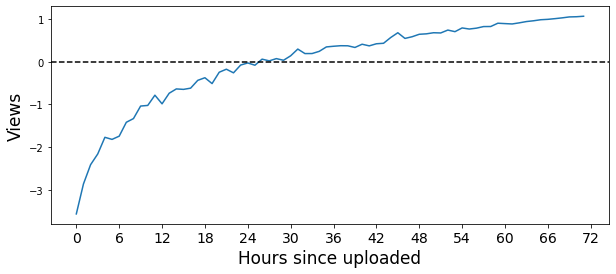

In [7]:
plt.figure(figsize = (10,4))
plt.plot(norm_ts)

plt.xlabel("Hours since uploaded", fontsize = 17)
plt.xticks(np.arange(0,78,6),fontsize = 14)

plt.ylabel("Views", fontsize = 17)
plt.axhline(0, color = "k", linestyle = "--")

In [8]:
adf_test(norm_ts)

ADF statistic: -4.161675
p-value: 0.000765


# Exponentiate

In [9]:
exp_ts = np.exp(norm_ts)

In [10]:
exp_ts

,0
0,0.028464
1,0.057348
2,0.090014
3,0.115659
4,0.170664
...,...
67,2.736190
68,2.786407
69,2.847628
70,2.860678


Text(0, 0.5, 'Exp norm Views')

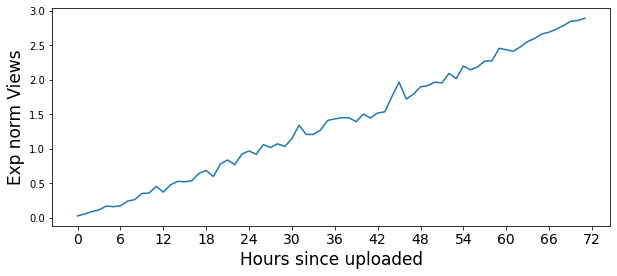

In [11]:
plt.figure(figsize = (10,4))
plt.plot(exp_ts)

plt.xlabel("Hours since uploaded", fontsize = 17)
plt.xticks(np.arange(0,78,6),fontsize = 14)

plt.ylabel("Exp norm Views", fontsize = 17)

In [12]:
adf_test(exp_ts)

ADF statistic: 1.648979
p-value: 0.997997


# First Difference

In [13]:
first_diff = exp_ts.diff().dropna()

Text(0, 0.5, 'First diff \nExp. norm. Views')

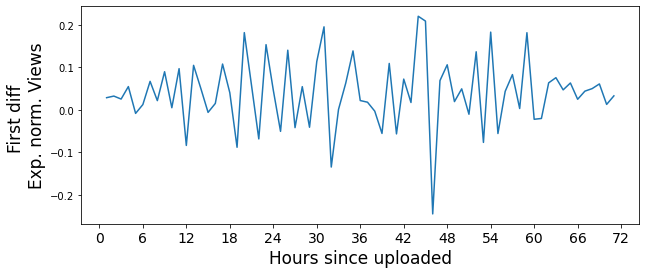

In [14]:
plt.figure(figsize = (10,4))
plt.plot(first_diff)

plt.xlabel("Hours since uploaded", fontsize = 17)
plt.xticks(np.arange(0,78,6),fontsize = 14)

plt.ylabel("First diff \nExp. norm. Views", fontsize = 17)


In [15]:
#adf test

adf_test(first_diff)

ADF statistic: -4.881064
p-value: 0.000038


# PACF Plot

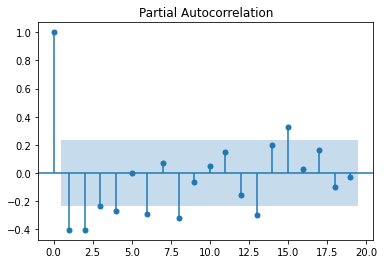

In [16]:
plot_pacf(first_diff)
plt.show()

# ACF Plot

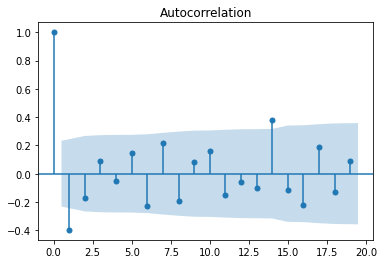

In [17]:
plot_acf(first_diff)
plt.show()

**According to the pacf and acf plot we can try AR(4) and MA(1) model**

# FIT ARMA model

In [18]:
model = ARMA(first_diff, order = (4,1))

model_fit = model.fit()

In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      0   No. Observations:                   71
Model:                     ARMA(4, 1)   Log Likelihood                  93.821
Method:                       css-mle   S.D. of innovations              0.064
Date:                Fri, 03 Dec 2021   AIC                           -173.641
Time:                        00:20:16   BIC                           -157.803
Sample:                             0   HQIC                          -167.343
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0409      0.002     24.378      0.000       0.038       0.044
ar.L1.0        0.0023      0.211      0.011      0.991      -0.411       0.415
ar.L2.0       -0.1749      0.173     -1.011      0.312      -0.514       0.164
ar.L3.0       -0.0030      0.161     -0.018      0.985      -0.318       0.312
ar.L4.0       -0.0538      0.141     -0.382      0.702      -0.330       0.222
ma.L1.0       -0.7421      0.181     -4.108      0.000      -1.096      -0.388
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1453           -1.7141j            2.0615           -0.1563
AR.2            1.1453           +1.7141j            2.0615            0.1563
AR.3           -1.1727           -1.7306j            2.0905           -0.3448
AR.4           -1.1727           +1.7306j            2.0905            0.3448
MA.1            1.3475           +0.0000j            1.3475            0.0000
-----------------------------------------------------------------------------
"""

# Predict 3 hours

In [20]:
prediction_info = model_fit.forecast(3)

In [26]:
# rediction_info[0]
# prediction_info[2][:, 0]p

In [27]:
predictions = prediction_info[0]
lower_bound = prediction_info[2][:,0]
upper_bound = prediction_info[2][:, 1]

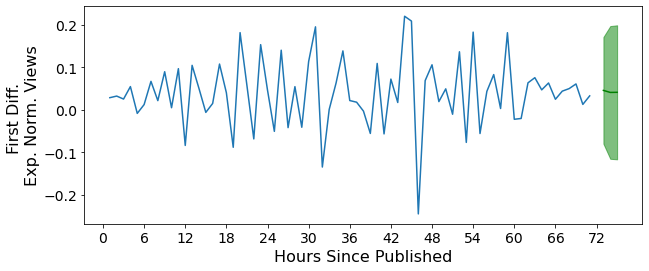

In [28]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), predictions, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), lower_bound, upper_bound, color='g', alpha=0.5)

# Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)
### $\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

In [30]:
def undo_transformation(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0]+np.exp((series.iloc[-1])-mu/sigma))+ mu
    orig_pred = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1]+np.exp((orig_pred[-1])-mu/sigma))+mu
        orig_pred.append(next_pred)
        
    return np.array(orig_pred).flatten()

In [46]:
st_pred = sigma*np.log(predictions[0]+np.exp((ts.iloc[-1])-mu/sigma))+ mu
r = [st_pred]
x = np.array(r).flatten()
x


array([inf])

In [31]:
orig_preds = undo_transformation(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformation(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformation(upper_bound, ts, mu, sigma)

In [40]:
orig_lower_bound

array([inf, inf, inf])

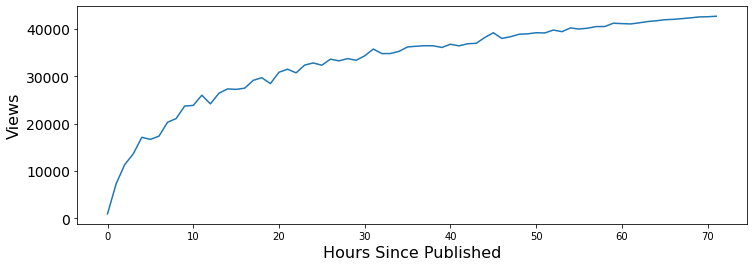

In [38]:
plt.figure(figsize=(12,4))
plt.plot(ts)

#plt.xticks(np.arange(0,84,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.5)

(40000.0, 45000.0)

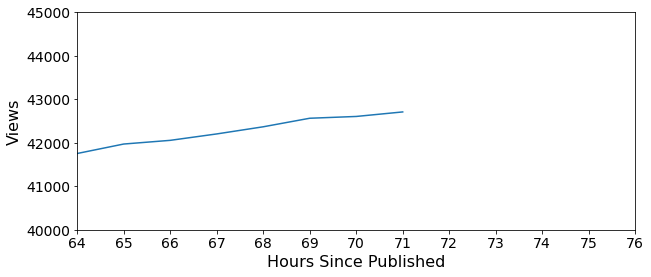

In [39]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.5)
plt.xlim(64,76)
plt.ylim(40000, 45000)